In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

In [135]:
df = pd.read_csv('exoplanets_cleaned.csv')
df

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_orbeccen,pl_eqt,st_teff,st_rad,st_mass,habitability_class,habitability_encoded
0,55 Cnc e,55 Cnc,0,2,5,Radial Velocity,0.736544,0.01544,2.080000,0.185565,0.06100,1958.0,5234.0,0.943,0.905,Not-Habitable Terrestrial,3
1,AU Mic b,AU Mic,0,1,3,Transit,8.463000,0.06450,4.070000,0.363102,0.00000,593.0,3700.0,0.750,0.500,Not-Habitable Terrestrial,3
2,AU Mic b,AU Mic,1,1,3,Transit,8.463080,0.06490,3.956770,0.353000,0.00577,600.0,3678.0,0.744,0.510,Not-Habitable Terrestrial,3
3,AU Mic c,AU Mic,0,1,3,Transit,18.859019,0.11010,3.240000,0.289054,0.00000,454.0,3700.0,0.750,0.500,Not-Habitable Terrestrial,3
4,AU Mic c,AU Mic,1,1,3,Transit,18.859690,0.11080,2.522021,0.225000,0.00338,459.0,3678.0,0.744,0.510,Not-Habitable Terrestrial,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,XO-5 b,XO-5,0,1,1,Transit,4.187757,0.04940,12.206601,1.089000,NaN,1203.0,5370.0,1.065,0.914,Hot Jupiters,2
15077,XO-6 b,XO-6,1,1,1,Transit,3.765001,0.08150,23.202630,2.070000,0.00000,1577.0,6720.0,1.930,1.470,Hot Jupiters,2
15078,XO-7 b,XO-7,1,1,1,Transit,2.864142,0.04421,15.389957,1.373000,0.03800,1743.0,6250.0,1.480,1.405,Hot Jupiters,2
15079,pi Men c,HD 39091,0,1,3,Transit,6.268340,0.06702,2.060000,0.183781,0.00000,1147.0,5870.0,1.100,1.020,Not-Habitable Terrestrial,3


In [136]:
label_encoder = LabelEncoder()
df['habitability_encoded'] = label_encoder.fit_transform(df['habitability_class'])

X = df[['pl_rade', 'pl_eqt', 'pl_orbper', 'pl_orbsmax', 'st_teff', 'st_rad', 'st_mass']].copy()
y = df['habitability_encoded']


In [137]:
for column in X.columns:
    median = X[column].median()
    X[column] = X[column].fillna(median)

In [138]:
nan_df = X.isnull().sum() * 100 / (X.count() + X.isnull().sum())
nan_df

pl_rade       0.0
pl_eqt        0.0
pl_orbper     0.0
pl_orbsmax    0.0
st_teff       0.0
st_rad        0.0
st_mass       0.0
dtype: float64

In [139]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

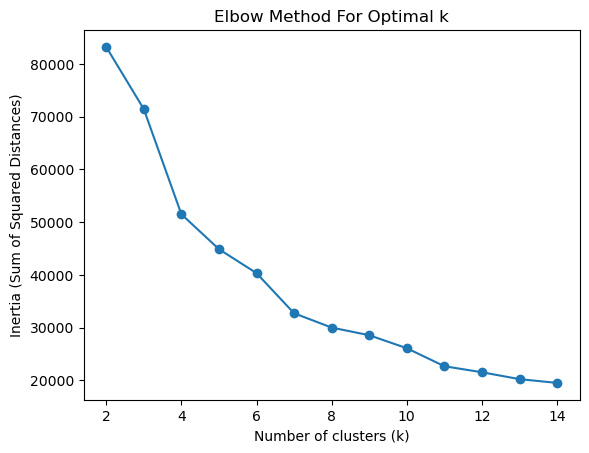

In [140]:
inertia = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.show()


In [141]:
def kmeans_clustering(data, n_clusters, n_init = 500, max_iter = 400, tol = 1e-3):
    kmeans = KMeans(n_clusters = n_clusters, n_init = n_init, max_iter = max_iter, tol = tol)
    kmeans.fit(data)
    data_clustered = data.copy()
    data_clustered['Cluster'] = kmeans.labels_

    return data_clustered

In [142]:
# Convert X_train_balanced back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Perform clustering
data_clustered = kmeans_clustering(X_scaled_df, 7)

In [143]:
data_clustered

,pl_rade,pl_eqt,pl_orbper,pl_orbsmax,st_teff,st_rad,st_mass,Cluster
0,-0.290405,2.677744,-0.604677,-0.910100,-0.353818,-0.105940,-0.098417,5
1,0.144393,-0.665841,-0.388764,-0.513210,-2.372501,-0.422399,-1.867621,2
2,0.119653,-0.648695,-0.388761,-0.509974,-2.401453,-0.432237,-1.823937,2
3,-0.036955,-1.006323,-0.098250,-0.144311,-2.372501,-0.422399,-1.867621,2
4,-0.193827,-0.994076,-0.098232,-0.138648,-2.401453,-0.432237,-1.823937,2
...,...,...,...,...,...,...,...,...
15076,1.922170,0.828362,-0.508234,-0.635367,-0.174848,0.094101,-0.059101,3
15077,4.324708,1.744479,-0.520047,-0.375681,1.601698,1.512427,2.369733,3
15078,2.617706,2.151098,-0.545222,-0.677354,0.983197,0.774570,2.085787,3
15079,-0.294775,0.691189,-0.450092,-0.492823,0.483132,0.151490,0.403950,5


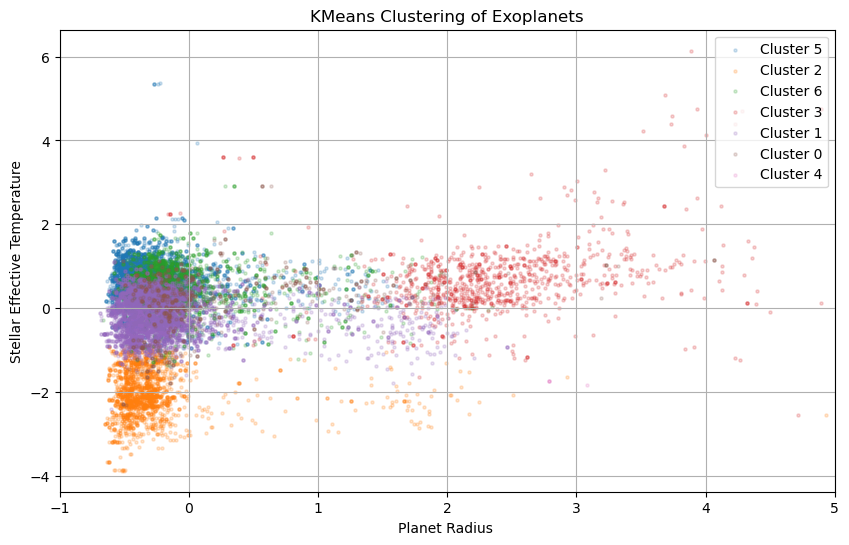

In [162]:
plt.figure(figsize=(10, 6))
for cluster in data_clustered['Cluster'].unique():
    cluster_data = data_clustered[data_clustered['Cluster'] == cluster]
    plt.scatter(cluster_data['pl_rade'], cluster_data['st_teff'], label=f'Cluster {cluster}', alpha=0.2, s=5)
plt.legend()
# plt.ylim(-0.2, 0.2)
plt.xlim(-1,5)
plt.xlabel('Planet Radius ')
plt.ylabel('Stellar Effective Temperature')
plt.title('KMeans Clustering of Exoplanets')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

In [156]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled_df)
X_pca

array([[ 1.30535571e+00, -1.75633217e+00, -1.15076179e-01,
         1.85083299e-01,  1.91629836e+00],
       [-2.28211226e+00, -1.67292020e+00,  1.29020753e+00,
         6.82854105e-01, -1.66350474e-02],
       [-2.27465960e+00, -1.67550934e+00,  1.26892068e+00,
         6.89773152e-01, -1.51845187e-03],
       ...,
       [ 3.73423147e+00,  4.99592143e-03,  1.61542336e+00,
        -1.03985041e+00,  3.80273413e-01],
       [ 9.44521152e-01, -4.85896781e-01, -5.24997151e-01,
        -1.42082724e-02,  1.54869726e-01],
       [ 1.23104716e+00, -3.36932232e-01, -6.79988901e-01,
        -1.37536200e-01,  1.08703676e-01]])

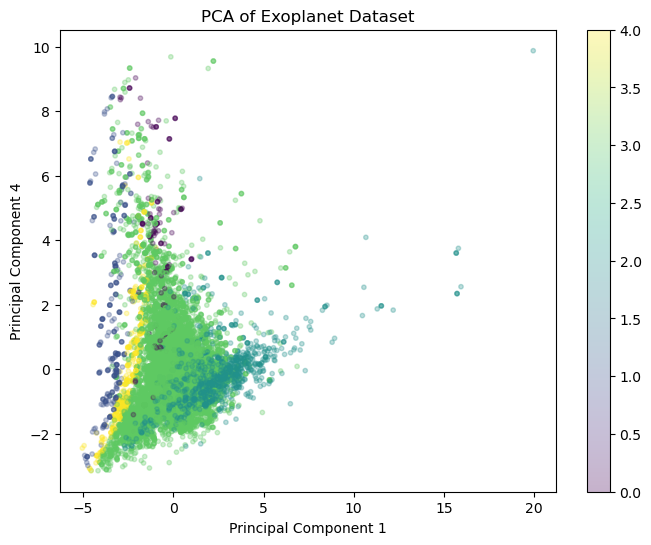

In [168]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.3, s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 4')
plt.title('PCA of Exoplanet Dataset')
# plt.ylim(-4, 4)
plt.colorbar(scatter)
plt.show()

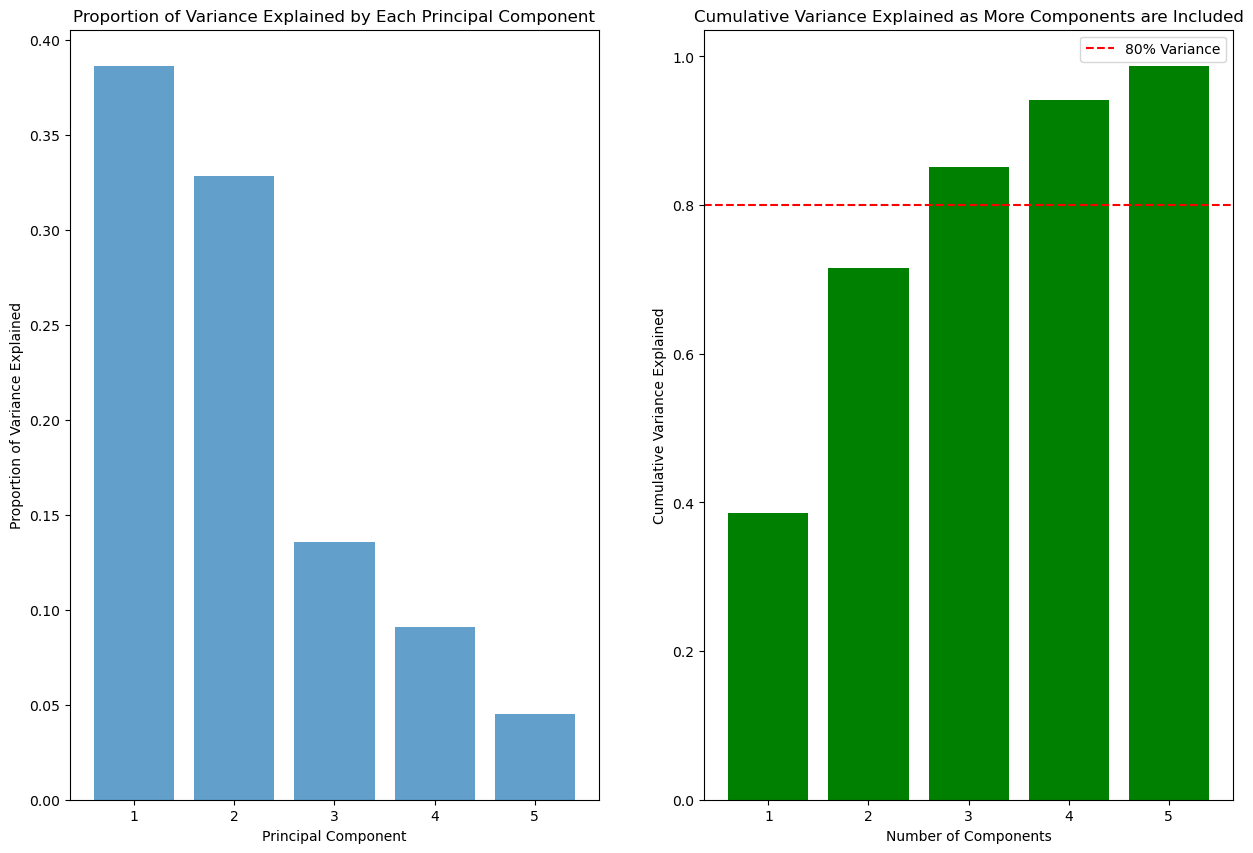

In [169]:
proportion_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(proportion_variance)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plot for the percentage variance explained by each component
axes[0].bar(range(1, len(proportion_variance) + 1), proportion_variance, alpha=0.7, label='Individual explained variance')
axes[0].set_title('Proportion of Variance Explained by Each Principal Component')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Proportion of Variance Explained')

# Plot for the cumulative variance explained by each component
axes[1].bar(range(1, len(cumulative_variance) + 1), cumulative_variance, color='green')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% Variance')
axes[1].set_title('Cumulative Variance Explained as More Components are Included')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].legend()

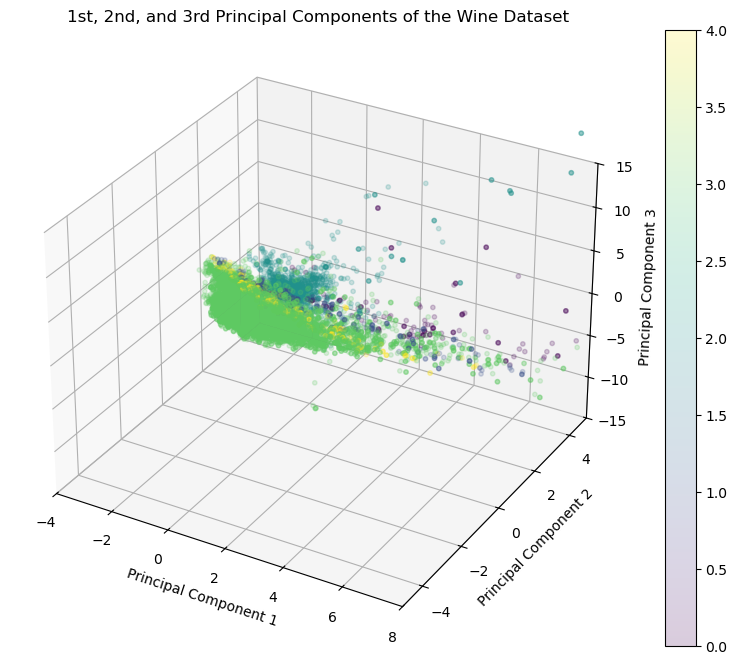

In [175]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting


pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Plotting the principal components in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 1], X_pca[:, 2], X_pca[:, 3], c=y, cmap='viridis', s=10, alpha=0.2)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_xlim(-4, 8)  # Set x-axis limits
ax.set_ylim(-5, 5)  # Set y-axis limits
ax.set_zlim(-15, 15)  # Set z-axis limits
# Set axis limits if needed (example values provided, adjust as necessary)
plt.title('1st, 2nd, and 3rd Principal Components of the Wine Dataset')
plt.colorbar(scatter)
plt.show()

In [176]:
from matplotlib.animation import FuncAnimation

# Creating the animation
def update(frame):
    ax.view_init(elev=10, azim=frame)


ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
plt.show()

In [177]:
# Save animation
ani.save('pca_rotation.gif', writer='imagemagick', fps=20)

MovieWriter imagemagick unavailable; using Pillow instead.


In [178]:
# List of your features
feature_names = ['pl_rade', 'pl_eqt', 'pl_orbper', 'pl_orbsmax', 'st_teff', 'st_rad', 'st_mass']

# Create a DataFrame of PCA loadings
loadings = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings

,pl_rade,pl_eqt,pl_orbper,pl_orbsmax,st_teff,st_rad,st_mass
PC1,0.235675,0.491236,-0.218269,-0.193341,0.442992,0.402455,0.509815
PC2,0.098509,-0.244763,0.588701,0.621189,0.295568,0.176092,0.282089
PC3,0.871893,0.025942,0.074109,0.023829,-0.382942,0.201764,-0.213812
PC4,-0.394493,0.027292,0.046049,0.035865,-0.372325,0.825978,-0.139133
PC5,-0.125653,0.813356,0.451202,0.127908,-0.139537,-0.213236,-0.194368
